
# GEOS 518 Notebook 3: ARMA Models

## By: Zakk Hess
## March 16th, 2018

### Overview of Analysis

In this analysis each of the following procedures will be executed on a timeseries of daily observed temperature at Bogus Basin (Idaho, USA).
Dataset downloaded from SNOTEL site through the NRCS (https://www.wcc.nrcs.usda.gov/snow/)

    1. Load your dataset that you've been using in previous notebooks
    2. Split your dataset into a training and test dataset
    3. Fit the parameters of the following models to your training dataset:
        -AR(2)
        -ARMA(2,2)
    4. Using the test portion of the dataset, compare the observations, AR(2), and ARMA(2,2) predictions for the following lead times:
        -1 time period ahead
        -3 time periods ahead
        -5 time periods ahead
    5. Characterize on the accuracy of the forecasts for each lead time and model
    6. Comment on and contrast modeling approaches

## 1. Load in the dataset and perform any necessary pre-processing 

In [232]:
#import libraries to be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import statsmodels.tsa.api as sm
from pandas.core import datetools



df = pd.read_csv('BB_AirT_12_17.csv', names=['Y','M','D','T(C)']) #load CSV into variable df
df['SerialDates'] = pd.to_datetime(df.Y*10000+df.M*100+df.D,format='%Y%m%d') #use YMD to make date (SerialDates)


# Create a Water Year column for our pandas data frame
WY = np.zeros(len(df['Y'].index)) #Create an empty array of zeros length of years
WY[df['M'].values < 10] = df['Y'].values[df['M'].values < 10] #records where the month is less than 10, their associated year is the correct water year
WY[df['M'].values >= 10] = df['Y'].values[df['M'].values >= 10] + 1 #records where the month is greater than or equal to 10,the correct water year is one more than the current calendar year
df['WY'] = WY.astype(int) #create column water year in data frame as an integer

## 2. Splitting dataset into "training" dataset used to estimate the parameters of the models, and a "test" dataset to test the model

In [233]:
df_train = df[df.WY != 2016] #create training dataset, everything not WY 016
df_test  = df[df.WY == 2016] #create test dataset, all of WY 2016

Ttrain = df_train['T(C)'].values #training data
Ttest  = df_test['T(C)'].values #test data

## 3. Fit the parameters of the models to the "training" dataset

## AR(2) Model

In [234]:
T = df_train['T(C)'].values #training
Tt = pd.Series(df_train['T(C)'].values, df_train['SerialDates'].values) #time series of T and Serial dates
DatesTest = df_test['SerialDates'].values #dates for test data

T_AR2_model = sm.AR(Tt).fit(2) #fit data with AR(2) model
print(T_AR2_model.params) #print parameters

Tttm1 = np.concatenate([Ttrain[-2:-1],Ttest[0:-1]]) #add extra spots for adjustment of 1 day lag
Tttm2 = np.concatenate([Ttrain[-3:-1],Ttest[0:-2]]) #add extra spots for adjustment of 2 day lag

AR2_mu   = T_AR2_model.params[0] #AR2 mu variable from statsmodel parameters
AR2_phi1 = T_AR2_model.params[1] #AR2 phi1 variable from statsmodel parameters 
AR2_phi2 = T_AR2_model.params[2] #AR2 phi2 variable from statsmodel parameters

ThatAR2 = AR2_mu + AR2_phi1*Tttm1 + AR2_phi2*Tttm2 #modeled values of AR(2) model

const    0.416538
L1.y     1.051570
L2.y    -0.118172
dtype: float64


### Plot AR(2) Vs. Observed To Verify It's Correct

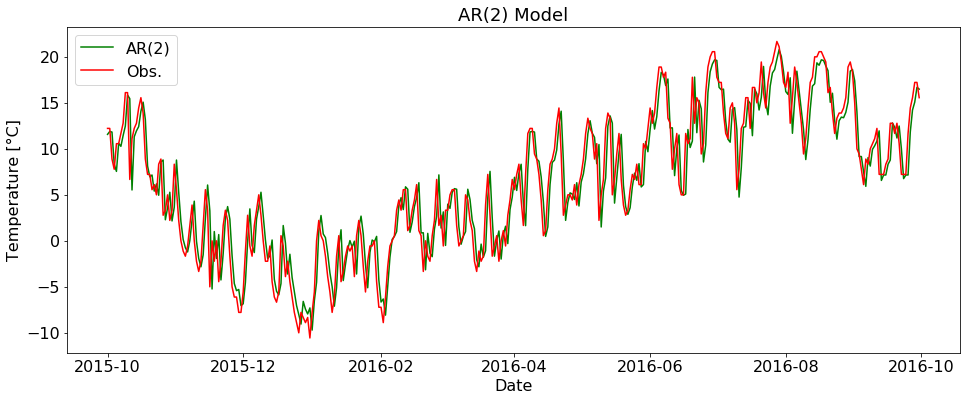

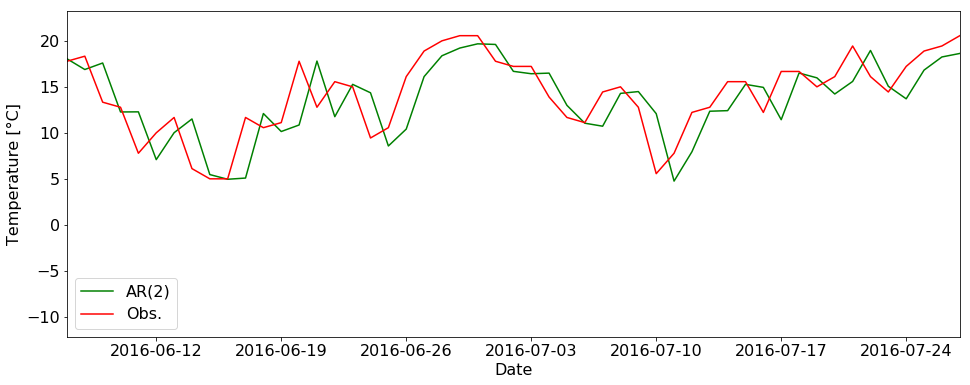

In [235]:
#create figure and plot AR2 modeled data and observed data
plt.figure(figsize=(16,6))

plt.plot(DatesTest,ThatAR2,'g-')
plt.plot(DatesTest,Ttest,'r-')
plt.ylabel('Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('AR(2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.title('AR(2) Model',fontsize=18)
plt.show()

#create figure and plot AR2 modeled data and observed data, "zoomed in"
plt.figure(figsize=(16,6))
plt.plot(DatesTest,ThatAR2,'g-')
plt.plot(DatesTest,Ttest,'r-')
plt.xlim([DatesTest[250],DatesTest[300]])
plt.ylabel('Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('AR(2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

## ARMA(2,2) Model

In [236]:
noise_std = 2.662 #std. error of AR(2) model std. 

Ttrain = df_train['T(C)'].values
Ttrain = Ttrain.reshape(Ttrain.size,1)

Ttest  = df_test['T(C)'].values
Ttest  = Ttest.reshape(Ttest.size,1)

DatesTest = df_test['SerialDates'].values
T = df_train['T(C)'].values #training
Tt = pd.Series(df_train['T(C)'].values, df_train['SerialDates'].values) #time series of T and Serial dates


T_ARMA_2_2_model = sm.ARMA(Tt-np.mean(Tt),(2,2)).fit() #fit data with ARMA(2,2) model
print(T_ARMA_2_2_model.params) #print parameters

ARMA22_mu     = T_ARMA_2_2_model.params[0] #YW eqution mu var
ARMA22_phi1   = T_ARMA_2_2_model.params[1] #YW eqution phi1 var
ARMA22_phi2   = T_ARMA_2_2_model.params[2] #YW equation phi2 var
ARMA22_theta1 = T_ARMA_2_2_model.params[3] #YW equation theta1 var
ARMA22_theta2 = T_ARMA_2_2_model.params[4] #YW equation theta2 var

Tttm1 = np.concatenate([Ttrain[-2:-1],Ttest[0:-1]]) #add extra spots for adjustment of 1 day lag
Tttm1 = Tttm1.reshape(Tttm1.size,1) #reshape

Tttm2 = np.concatenate([Ttrain[-3:-1],Ttest[0:-2]]) #add extra spots for adjustment of 2 day lag
Tttm2 = Tttm2.reshape(Tttm2.size,1) #reshape

etatm1 = np.random.normal(0.0,noise_std,(len(Tttm1),1)) #noise var.
etatm2 = np.concatenate([np.random.normal(0.0,noise_std,(2,1)),etatm1[0:-2]]) #noise var.

ThatARMA22 = ARMA22_mu + ARMA22_phi1*Tttm1 + ARMA22_phi2*Tttm2 - ARMA22_theta1*etatm1 - ARMA22_theta2*etatm2 #modeled values of ARMA(2,2)

const      0.181670
ar.L1.y    1.474398
ar.L2.y   -0.479224
ma.L1.y   -0.422281
ma.L2.y   -0.383984
dtype: float64


### Plot ARMA(2,2) Vs. Observed To Verify It's Correct

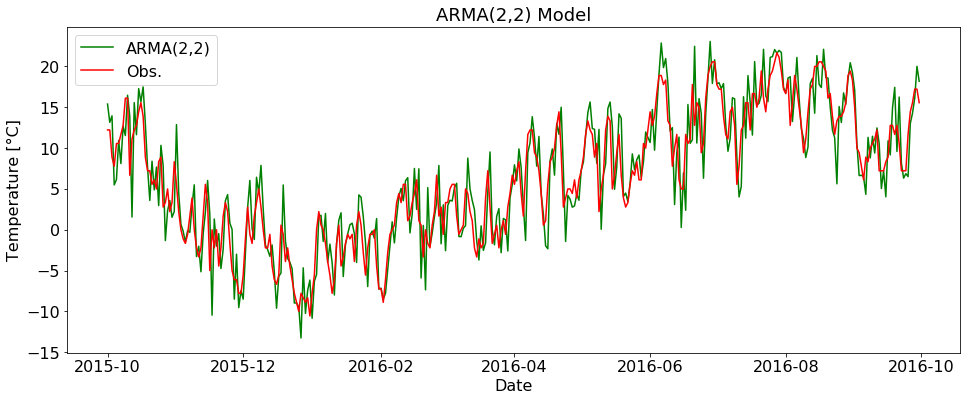

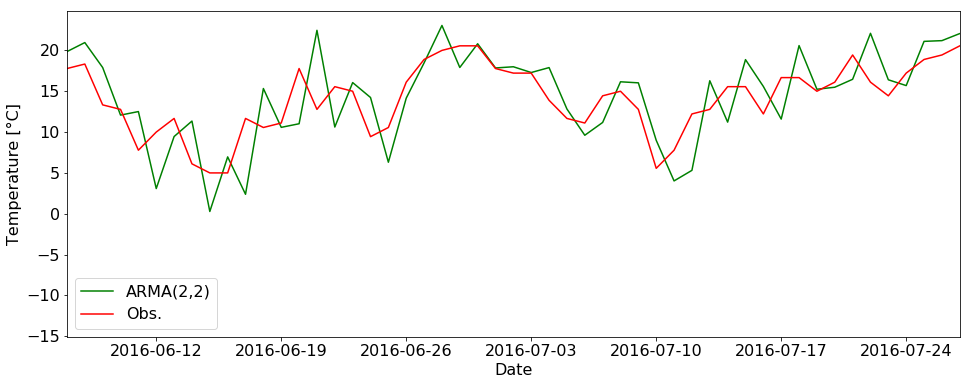

In [237]:
#create figure and plot ARMA(2,2) modeled data and observed data
plt.figure(figsize=(16,6))

plt.plot(DatesTest,ThatARMA22,'g-')
plt.plot(DatesTest,Ttest,'r-')
plt.ylabel('Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('ARMA(2,2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.title('ARMA(2,2) Model',fontsize=18)
plt.show()

#create figure and plot ARMA(2,2) modeled data and observed data, "zoomed in"
plt.figure(figsize=(16,6))
plt.plot(DatesTest,ThatARMA22,'g-')
plt.plot(DatesTest,Ttest,'r-')
plt.xlim([DatesTest[250],DatesTest[300]])
plt.ylabel('Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('ARMA(2,2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

## 4. Compare the observations, AR(2), and ARMA(2,2) predictions for lead times:
    1 time period ahead
    3 time periods ahead
    5 time periods ahead

## AR(2) Model - Lead Times

In [238]:
#Readd this data so it overwrites variables from ARMA(2,2) model fit
Ttrain = df_train['T(C)'].values #training data
Ttest  = df_test['T(C)'].values #test data
Tttm1 = np.concatenate([Ttrain[-2:-1],Ttest[0:-1]]) #add extra spots for adjustment of 1 day lag

# Determine AR(2) model output for lead times 1-5
Tt = ThatAR2
ThatAR2_1 = AR2_mu + AR2_phi1*Tt + AR2_phi2*Tttm1 #one time period
ThatAR2_2 = AR2_mu + AR2_phi1*ThatAR2_1 + AR2_phi2*ThatAR2
ThatAR2_3 = AR2_mu + AR2_phi1*ThatAR2_2 + AR2_phi2*ThatAR2_1 #three time periods
ThatAR2_4 = AR2_mu + AR2_phi1*ThatAR2_3 + AR2_phi2*ThatAR2_2
ThatAR2_5 = AR2_mu + AR2_phi1*ThatAR2_4 + AR2_phi2*ThatAR2_3 #fiver time periods

### Plot the AR(2) model and AR(2) models with varying lead times against the observed data

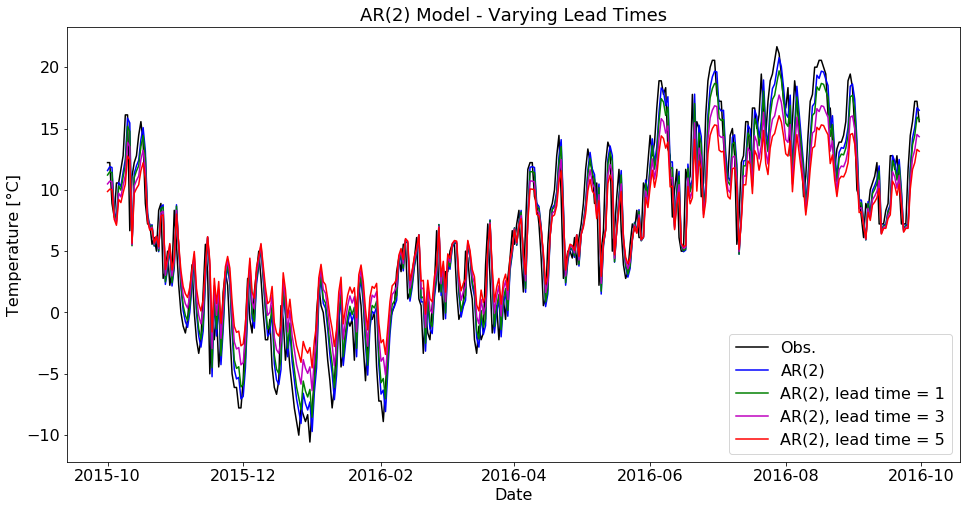

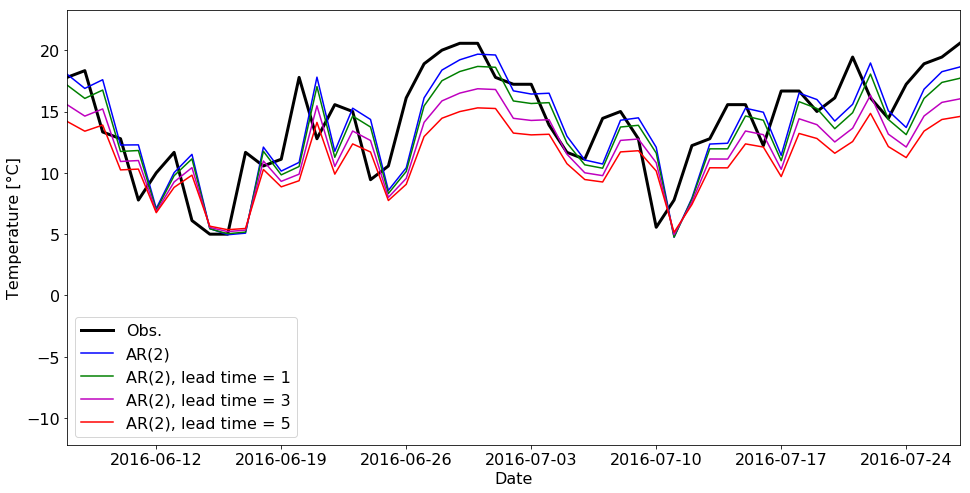

In [239]:
# plot Observed, AR(2) model, and AR(2) model at lead times 1,3 and 5
plt.figure(figsize=(16,8))
plt.plot(DatesTest,Ttest,'k-') #observed
plt.plot(DatesTest,ThatAR2,'b-') #AR(2) model
plt.plot(DatesTest,ThatAR2_1,'g-') #AR(2) model, 1 lead times
plt.plot(DatesTest,ThatAR2_3,'m-') #AR(2) model, 3 lead times
plt.plot(DatesTest,ThatAR2_5,'r-') #AR(2) model, 5 lead times
plt.ylabel('Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('Obs.','AR(2)','AR(2), lead time = 1','AR(2), lead time = 3','AR(2), lead time = 5'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.title('AR(2) Model - Varying Lead Times',fontsize=18)
plt.show()

# plot Observed, AR(2) model, and AR(2) model at lead times 1,3 and 5, "zoomed in"
plt.figure(figsize=(16,8))
plt.plot(DatesTest,Ttest,'k-',linewidth=3) #observed
plt.plot(DatesTest,ThatAR2,'b-') #AR(2) model
plt.plot(DatesTest,ThatAR2_1,'g-') #AR(2) model, 1 lead times
plt.plot(DatesTest,ThatAR2_3,'m-') #AR(2) model, 3 lead times
plt.plot(DatesTest,ThatAR2_5,'r-') #AR(2) model, 5 lead times
plt.xlim([DatesTest[250],DatesTest[300]])
plt.ylabel('Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('Obs.','AR(2)','AR(2), lead time = 1','AR(2), lead time = 3','AR(2), lead time = 5'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

## ARMA(2,2) Model - Lead Times

In [244]:
noise_std = 2.662 #std. error of AR(2) model std. 

#Overwrite vars from AR(2)
Ttrain = Ttrain.reshape(Ttrain.size,1) #reshape
Ttest  = Ttest.reshape(Ttest.size,1) #reshape
Tttm1 = Tttm1.reshape(Tttm1.size,1) #reshape
Tttm2 = Tttm2.reshape(Tttm2.size,1) #reshape

# Determine ARMA(2,2) model output for lead times 1-5
ThatARMA22_1 = ARMA22_mu + ARMA22_phi1*ThatARMA22 + ARMA22_phi2*Tttm1 - ARMA22_theta1*etatm1 - ARMA22_theta2*etatm2
ThatARMA22_2 = ARMA22_mu + ARMA22_phi1*ThatARMA22_1 + ARMA22_phi2*ThatARMA22 - ARMA22_theta1*0 - ARMA22_theta2*etatm1
ThatARMA22_3 = ARMA22_mu + ARMA22_phi1*ThatARMA22_2 + ARMA22_phi2*ThatARMA22_1 - ARMA22_theta1*0 - ARMA22_theta2*0
ThatARMA22_4 = ARMA22_mu + ARMA22_phi1*ThatARMA22_3 + ARMA22_phi2*ThatARMA22_2 - ARMA22_theta1*0 - ARMA22_theta2*0
ThatARMA22_5 = ARMA22_mu + ARMA22_phi1*ThatARMA22_4 + ARMA22_phi2*ThatARMA22_3 - ARMA22_theta1*0 - ARMA22_theta2*0

### Plot the ARMA(2,2) model and ARMA(2,2)  models with varying lead times against the observed data

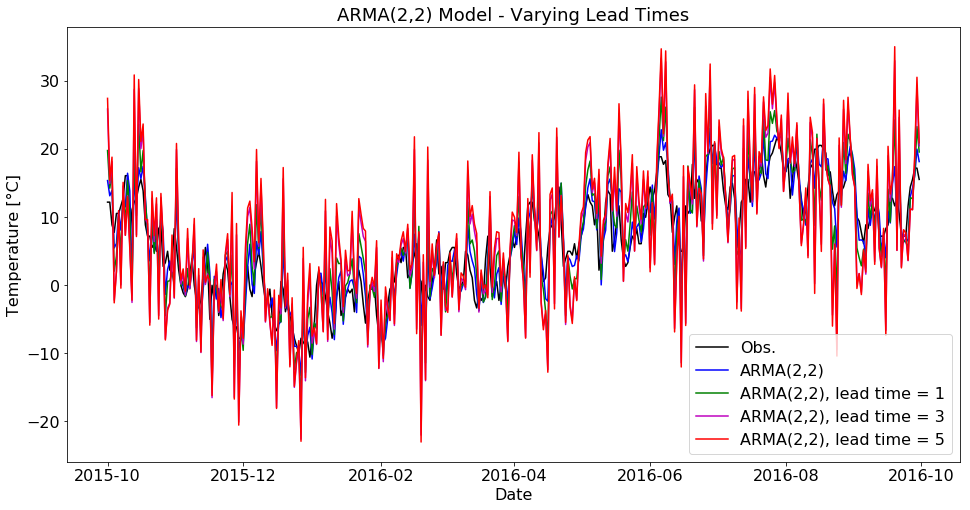

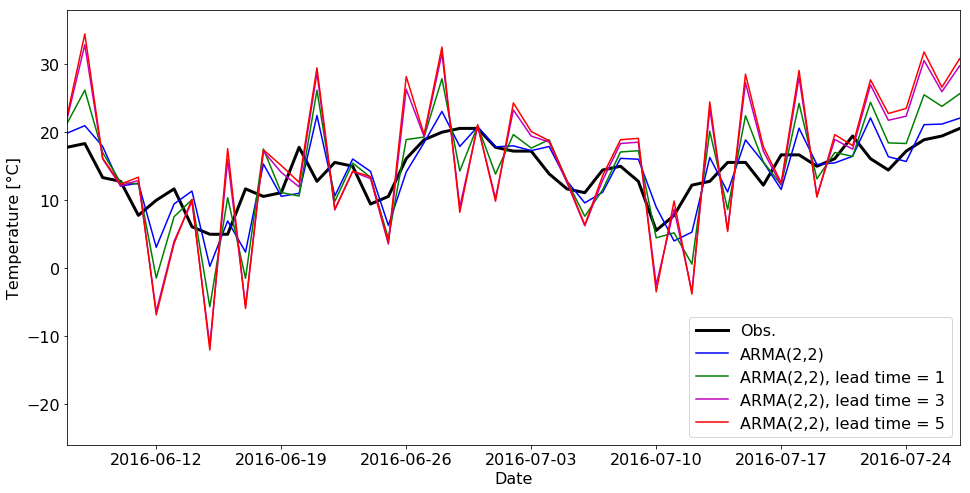

In [241]:
# plot Observed, ARMA(2,2) model, and ARMA(2,2) model at lead times 1,3 and 5
plt.figure(figsize=(16,8))
plt.plot(DatesTest,Ttest,'k-') #observed
plt.plot(DatesTest,ThatARMA22,'b-') #ARMA(2,2) model
plt.plot(DatesTest,ThatARMA22_1,'g-') #ARMA(2,2) model, 1 lead times
plt.plot(DatesTest,ThatARMA22_3,'m-') #ARMA(2,2) model, 3 lead times
plt.plot(DatesTest,ThatARMA22_5,'r-') #ARMA(2,2) model, 5 lead times
plt.ylabel('Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('Obs.','ARMA(2,2)','ARMA(2,2), lead time = 1','ARMA(2,2), lead time = 3','ARMA(2,2), lead time = 5'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.title('ARMA(2,2) Model - Varying Lead Times',fontsize=18)
plt.show()

# plot Observed, ARMA(2,2) model, and ARMA(2,2) model at lead times 1,3 and 5, "zoomed in"
plt.figure(figsize=(16,8))
plt.plot(DatesTest,Ttest,'k-',linewidth=3) #observed
plt.plot(DatesTest,ThatARMA22,'b-') #ARMA(2,2) model
plt.plot(DatesTest,ThatARMA22_1,'g-') #ARMA(2,2) model, 1 lead times
plt.plot(DatesTest,ThatARMA22_3,'m-') #ARMA(2,2) model, 3 lead times
plt.plot(DatesTest,ThatARMA22_5,'r-') #ARMA(2,2) model, 5 lead times
plt.xlim([DatesTest[250],DatesTest[300]])
plt.ylabel('Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('Obs.','ARMA(2,2)','ARMA(2,2), lead time = 1','ARMA(2,2), lead time = 3','ARMA(2,2), lead time = 5'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

## 5. Characterize on the accuracy of the forecasts for each lead time and model

### AR(2) Model

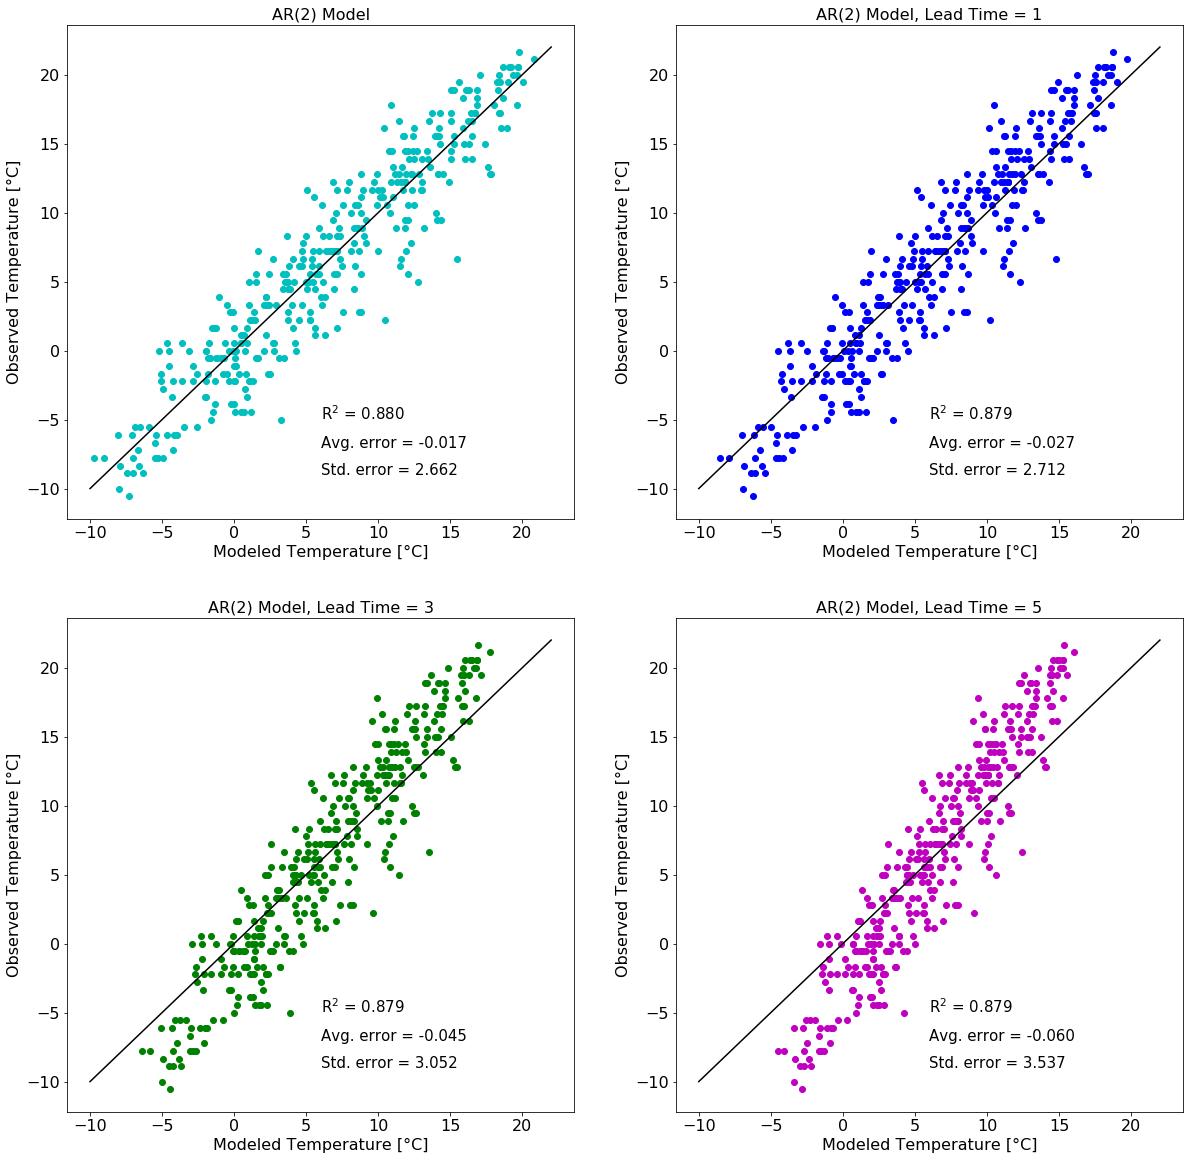

In [242]:
#overwrite ARMA(2,2) var
Ttest  = df_test['T(C)'].values #test data

# Compute the R^2 values and other statistics for each prediction 
#AR STATISTICS
#R^2
R2AR2     = np.corrcoef(ThatAR2,Ttest)**2
R2AR2_1  = np.corrcoef(ThatAR2_1,Ttest)**2
R2AR2_3  = np.corrcoef(ThatAR2_3,Ttest)**2
R2AR2_5  = np.corrcoef(ThatAR2_5,Ttest)**2
#Average Error
muAR2  = np.mean(ThatAR2-Ttest)
muAR2_1  = np.mean(ThatAR2_1-Ttest)
muAR2_3  = np.mean(ThatAR2_3-Ttest)
muAR2_5  = np.mean(ThatAR2_5-Ttest)
#Standard Error
stdAR2 = np.std(ThatAR2-Ttest)
stdAR2_1 = np.std(ThatAR2_1-Ttest)
stdAR2_3 = np.std(ThatAR2_3-Ttest)
stdAR2_5 = np.std(ThatAR2_5-Ttest)

# Plot the AR(1) and AR(2) model results 
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.plot(ThatAR2,Ttest,'co')
plt.plot([-10, 22], [-10, 22], 'k-')
plt.title('AR(2) Model',fontsize=16)
plt.ylabel('Observed Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Modeled Temperature [\N{DEGREE SIGN}C]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2AR2[0,1], xy=(6,-5), fontsize=15)
ax.annotate('Avg. error = %.3f'%muAR2, xy=(6,-7), fontsize=15)
ax.annotate('Std. error = %.3f'%stdAR2, xy=(6,-9), fontsize=15)
plt.subplot(222)
plt.plot(ThatAR2_1,Ttest,'bo')
plt.plot([-10, 22], [-10, 22], 'k-')
plt.title('AR(2) Model, Lead Time = 1',fontsize=16)
plt.ylabel('Observed Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Modeled Temperature [\N{DEGREE SIGN}C]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2AR2_1[0,1], xy=(6,-5), fontsize=15)
ax.annotate('Avg. error = %.3f'%muAR2_1, xy=(6,-7), fontsize=15)
ax.annotate('Std. error = %.3f'%stdAR2_1, xy=(6,-9), fontsize=15)
plt.subplot(223)
plt.plot(ThatAR2_3,Ttest,'go')
plt.plot([-10, 22], [-10, 22], 'k-')
plt.title('AR(2) Model, Lead Time = 3',fontsize=16)
plt.ylabel('Observed Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Modeled Temperature [\N{DEGREE SIGN}C]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2AR2_3[0,1], xy=(6,-5), fontsize=15)
ax.annotate('Avg. error = %.3f'%muAR2_3, xy=(6,-7), fontsize=15)
ax.annotate('Std. error = %.3f'%stdAR2_3, xy=(6,-9), fontsize=15)
plt.subplot(224)
plt.plot(ThatAR2_5,Ttest,'mo')
plt.plot([-10, 22], [-10, 22], 'k-')
plt.title('AR(2) Model, Lead Time = 5',fontsize=16)
plt.ylabel('Observed Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Modeled Temperature [\N{DEGREE SIGN}C]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2AR2_5[0,1], xy=(6,-5), fontsize=15)
ax.annotate('Avg. error = %.3f'%muAR2_5, xy=(6,-7), fontsize=15)
ax.annotate('Std. error = %.3f'%stdAR2_5, xy=(6,-9), fontsize=15)
plt.show()

### ARMA(2,2) Model

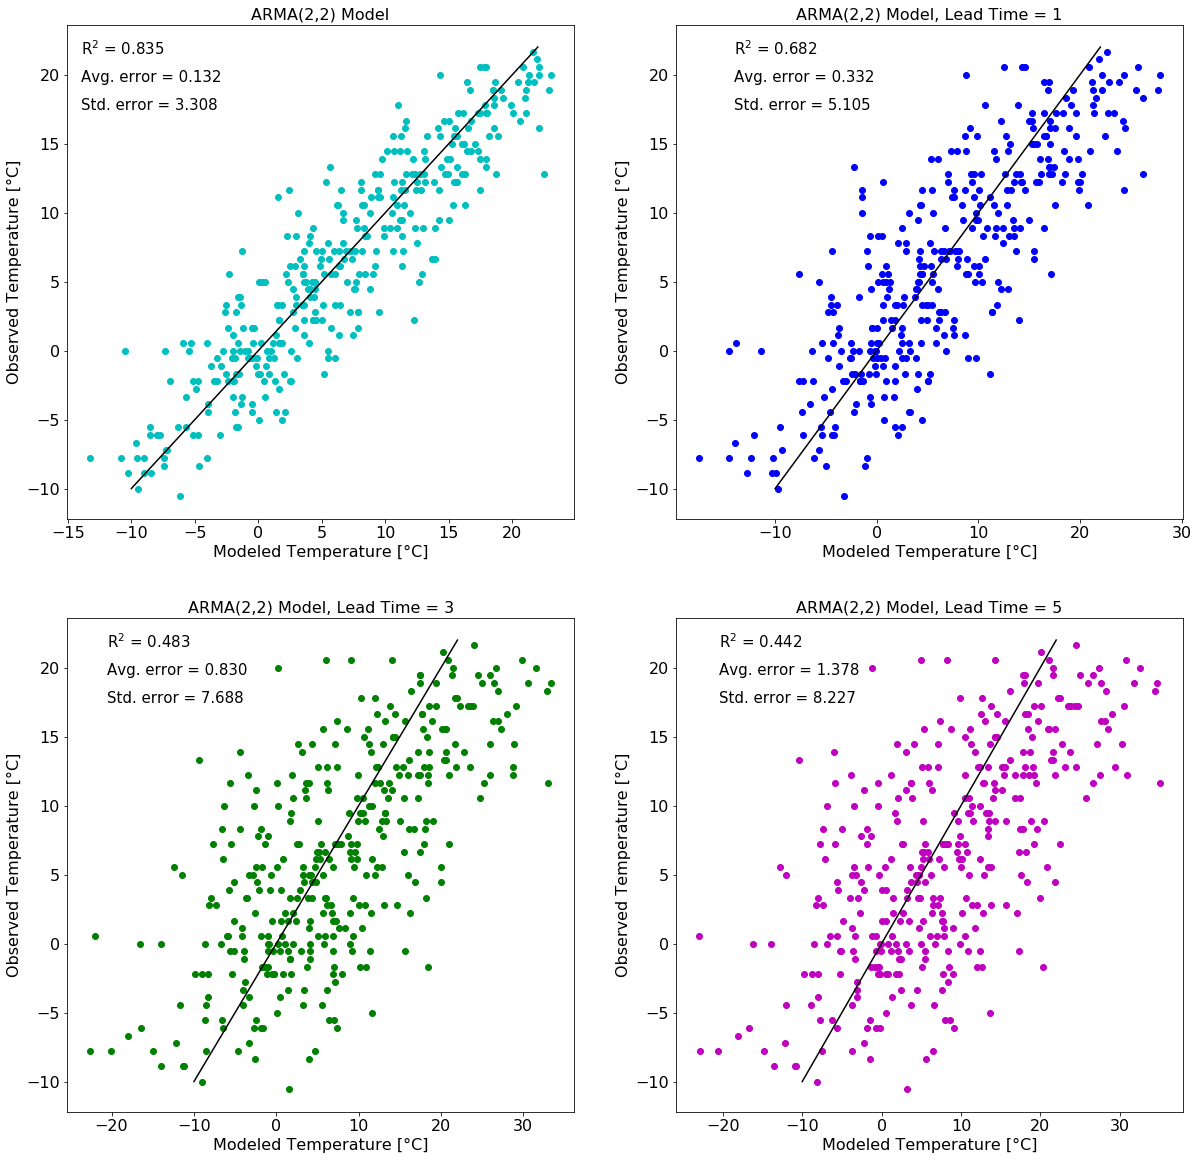

In [243]:
#overwrite ARMA(2,2) var
Ttest  = df_test['T(C)'].values
Ttest  = Ttest.reshape(Ttest.size,1)

# Compute the R^2 values and other statistics for each prediction 
#ARMA STATISTICS
#R^2
R2ARMA22     = np.corrcoef(ThatARMA22.T,Ttest.T)**2
R2ARMA22_1  = np.corrcoef(ThatARMA22_1.T,Ttest.T)**2
R2ARMA22_3  = np.corrcoef(ThatARMA22_3.T,Ttest.T)**2
R2ARMA22_5  = np.corrcoef(ThatARMA22_5.T,Ttest.T)**2
#Average Error
muARMA22  = np.mean(ThatARMA22-Ttest)
muARMA22_1  = np.mean(ThatARMA22_1-Ttest)
muARMA22_3  = np.mean(ThatARMA22_3-Ttest)
muARMA22_5  = np.mean(ThatARMA22_5-Ttest)
#Standard Error
stdARMA22 = np.std(ThatARMA22-Ttest)
stdARMA22_1 = np.std(ThatARMA22_1-Ttest)
stdARMA22_3 = np.std(ThatARMA22_3-Ttest)
stdARMA22_5 = np.std(ThatARMA22_5-Ttest)

# Plot the AR(1) and AR(2) model results 
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.plot(ThatARMA22,Ttest,'co')
plt.plot([-10, 22], [-10, 22], 'k-')
plt.title('ARMA(2,2) Model',fontsize=16)
plt.ylabel('Observed Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Modeled Temperature [\N{DEGREE SIGN}C]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2ARMA22[0,1], xy=(-14,21.5), fontsize=15)
ax.annotate('Avg. error = %.3f'%muARMA22, xy=(-14,19.5), fontsize=15)
ax.annotate('Std. error = %.3f'%stdARMA22, xy=(-14,17.5), fontsize=15)
plt.subplot(222)
plt.plot(ThatARMA22_1,Ttest,'bo')
plt.plot([-10, 22], [-10, 22], 'k-')
plt.title('ARMA(2,2) Model, Lead Time = 1',fontsize=16)
plt.ylabel('Observed Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Modeled Temperature [\N{DEGREE SIGN}C]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2ARMA22_1[0,1], xy=(-14,21.5), fontsize=15)
ax.annotate('Avg. error = %.3f'%muARMA22_1, xy=(-14,19.5), fontsize=15)
ax.annotate('Std. error = %.3f'%stdARMA22_1, xy=(-14,17.5), fontsize=15)
plt.subplot(223)
plt.plot(ThatARMA22_3,Ttest,'go')
plt.plot([-10, 22], [-10, 22], 'k-')
plt.title('ARMA(2,2) Model, Lead Time = 3',fontsize=16)
plt.ylabel('Observed Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Modeled Temperature [\N{DEGREE SIGN}C]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2ARMA22_3[0,1], xy=(-20.5,21.5), fontsize=15)
ax.annotate('Avg. error = %.3f'%muARMA22_3, xy=(-20.5,19.5), fontsize=15)
ax.annotate('Std. error = %.3f'%stdARMA22_3, xy=(-20.5,17.5), fontsize=15)
plt.subplot(224)
plt.plot(ThatARMA22_5,Ttest,'mo')
plt.plot([-10, 22], [-10, 22], 'k-')
plt.title('ARMA(2,2) Model, Lead Time = 5',fontsize=16)
plt.ylabel('Observed Temperature [\N{DEGREE SIGN}C]',fontsize=16)
plt.xlabel('Modeled Temperature [\N{DEGREE SIGN}C]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2ARMA22_5[0,1], xy=(-20.5,21.5), fontsize=15)
ax.annotate('Avg. error = %.3f'%muARMA22_5, xy=(-20.5,19.5), fontsize=15)
ax.annotate('Std. error = %.3f'%stdARMA22_5, xy=(-20.5,17.5), fontsize=15)
plt.show()

## 6. Comment on and contrast modeling approaches

### AR(2) Model

The AR(2) model does a good job of modeling what the observed temperatures are. As can be seen in the plot of AR(2) model output vs. observed, the data is lagged by a time step, due to the nature of the model, but performs quite well. The R^2 value between the observed temperatures and AR(2) modeled temperatures is 0.880.

#### Differing Timesteps
 
As the lead time increases for the AR(2) model the output becomes quite a bit different. In the plot of modeled ouput, qualitatively there is an obvious difference. As the lead time increases, the ouput deviates further (decreasing) from the observed temperature, however, the ouput follows a similar trend. Due to a similar trend, but decreasing accuracy, the R^2 value stays about the same as lead time increases, 0.880 to 0.879. The big difference is that as lead time increases, both the average error and standard error increase. With no lead time the average error is -0.017 and the standard error is 2.662, at lead time of 5 the average error and standard error are -0.060 and 3.537 respectively.

### ARMA(2,2) Model

The ARMA(2,2) model performs well having an R^2 value with the observed temperature data of 0.835. The ARMA(2,2) unlike the AR(2) model doesn't quite follow the same trend as the original temperature data, there are more fluctuations due to the noise component being taken into consideration.

#### Differing Timesteps

As lead time increases for the ARMA(2,2) model, like the AR(2) model, the modeled ouput deviates (decreasing) further from the observed temperature. As the lead time gets larger the amplitude of the fluctuations also increases. This increased amplitude of fluctuation timestep to timestep (daily) makes the ouput vary drastically from the observed temperature as lead time increases. Too much noise is considered that isn't natural in the system, a consequence of the model having numerous parameters that depend on the previous modeled output. As lead time increases the R^2, average error, and standard error get worse. With no lead time the R^2 value is 0.835, the average error is 0.132, and the standard error is 3.308, at lead time of 5 the R^2 value, average error, and standard error are 0.442, 1.378, and 8.227 respectively.

### Comparing AR(2), ARMA(2,2), and each at varying timesteps

The ARMA(2,2) model takes into consideration many parameters that're dependent on the previous estimation, thus as the lead time increases or the degree of the model increases, it gets more and more complicated and prone to error. Although the ARMA model takes into consideration random noise that may be relevant in the system, from my analysis, it is not a good model for replicating the observed temperatures at Bogus Basin. As lead time increases for both the AR(2) and ARMA(2,2) model their ouput gets worse (further from the observed). The best statistics for the AR(2) model are with no lead time which give R^2, average error, and standard error values of 0.880, -0.017, and 2.662. The best statistics from the ARMA(2,2) model are with no lead time as well, which give R^2, average error, and standard error values of 0.835, 0.132, and 3.308. The statistics show that the AR(2) model performs better and is the best fit for modeling the dataset of temperature at Bogus Basin.